In [1]:
#not needed for pipeline, just for testing
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from __future__ import division
from os.path import join, basename, exists
from os import makedirs
from glob import glob

from nilearn import input_data, datasets, plotting, regions
from nilearn.image import concat_imgs
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from scipy.stats import pearsonr

import bct
import json
import numpy as np
import pandas as pd

In [98]:
subjects = ['101', '102', '103', '104', '106', '107', '108', '110', '212',
            '214', '215', '216', '217', '218', '219', '320', '321', '323',
            '324', '325', '327', '328', '330', '331', '333', '334',
            '335', '336', '337', '338', '339', '340', '341', '342', '343', '344',
            '345', '346', '347', '348', '349', '350', '451', '453', '455',
            '458', '459', '460', '462', '463', '464', '465', '467',
            '468', '469', '470', '502', '503', '571', '572', '573', '574',
            '577', '578', '581', '582', '584', '585', '586', '587',
            '588', '589', '591', '592', '593', '594', '595', '596', '597',
            '598', '604', '605', '606', '607', '608', '609', '610', '612',
            '613', '614', '615', '617', '618', '619', '620', '621', '622',
            '623', '624', '625', '626', '627', '629', '630', '631', '633',
            '634']
#all subjects 102 103 101 104 106 107 108 110 212 X213 214 215 216 217 218 219 320 321 X322 323 324 325
#327 328 X329 330 331 X332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 451
#X452 453 455 X456 X457 458 459 460 462 463 464 465 467 468 469 470 502 503 571 572 573 574 X575 577 578
#X579 X580 581 582 584 585 586 587 588 589 X590 591 592 593 594 595 596 597 598 604 605 606 607 608 609
#610 X611 612 613 614 615 X616 617 618 619 620 621 622 623 624 625 626 627 X628 629 630 631 633 634
#errors in fnirt-to-mni: 213, 322, 329, 332, 452, 456, 457, 575, 579, 580, 590, 611, 616, 628
#subjects without post-IQ measure: 452, 461, 501, 575, 576, 579, 583, 611, 616, 628, 105, 109, 211, 213, 322, 326, 329, 332
#subjects = ['101','103']


#data_dir = '/home/data/nbc/physics-learning/data/pre-processed'
data_dir = '/home/data/nbc/physics-learning/retrieval-graphtheory/output'
timing_dir = '/home/data/nbc/physics-learning/data/behavioral-data/vectors'
#sink_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/data/out'

sessions = ['pre','post']

tasks = {'fci': [{'conditions': ['Physics', 'NonPhysics']},
         {'runs': [0,1,2]}],
         'reas': [{'conditions': ['Reasoning', 'Baseline']},
         {'runs': [0,1]}],
         'retr': [{'conditions': ['Physics', 'General']},
         {'runs': [0,1]}]}

masks = ['shen2015', 'craddock2012']

connectivity_metric = 'partial correlation'
conds = ['high-level', 'lower-level']

#find a way to estimate this threshold range...
#or threshold it 
thresh_range = np.arange(0.1, 1, 0.1)
highpass = 1/55.

correlation_measure = ConnectivityMeasure(kind=connectivity_metric)


index = pd.MultiIndex.from_product([subjects, sessions, tasks.keys(), conds,  masks], names=['subject', 'session', 'task', 'condition', 'mask'])
df = pd.DataFrame(columns=['k_scale-free', 'k_connected'], 
                  index=index, dtype=np.float64)

In [53]:
#the reasoning task timing is modeled a little differently
#"events" fall halfway between the presentation of the third screen and the ppt's button press
#so I'm thinking of taking the TR in which the event is modeled, the one before, and the one after
#ideally capturing the 6 seconds around decision making
#I don't think those 6 seconds overlap between trials, but I'll check
task = 'reas'
timing = {}
for run in tasks[task][1]['runs']:
    for condition in tasks[task][0]['conditions']:
        print(task, run, condition)
        timing[condition] = np.genfromtxt(join('/Users/Katie/Dropbox/Projects/physics-retrieval/data/', '{0}-{1}-{2}.txt'.format(task, run, condition)), 
                                          delimiter='\t', dtype='float')
        print(np.average(timing[condition][:,1]))
        print(timing[condition])
        #divide by 2 bc timing is in seconds and TRs are 2 seconds each
        #so data points represent 2s. intervals
        #subtracting 2 to (1) zero-index and (2) caputure the preceding TR
        timing[condition][:,0] = np.round(timing[condition][:,0]/2,0) - 2
        #all timing is 3 because I want the TR before
        #the TR halfway between screen 3 and decision
        #and the TR after halfway
        timing[condition][:,1] = np.round(np.round(timing[condition][:,1],0)/2,0)
        print(timing[condition])
        timing[condition] = timing[condition][:,0:2]
        print(timing[condition])

reas 0 Reasoning
2.0108235294117645
[[  9.4335   2.9335   1.    ]
 [ 37.838    3.322    1.    ]
 [ 65.8295   3.2975   1.    ]
 [105.6235   1.0755   1.    ]
 [120.286    1.738    1.    ]
 [148.5755   2.0115   1.    ]
 [162.688    2.124    1.    ]
 [176.2855   1.7055   1.    ]
 [204.0995   1.5205   1.    ]
 [232.3285   1.7325   1.    ]
 [245.6745   1.0625   1.    ]
 [275.263    2.651    1.    ]
 [302.5465   1.9185   1.    ]
 [316.497    1.869    1.    ]
 [329.551    0.907    1.    ]
 [359.252    2.592    1.    ]
 [372.3835   1.7235   1.    ]]
[[  3.   1.   1.]
 [ 17.   2.   1.]
 [ 31.   2.   1.]
 [ 51.   1.   1.]
 [ 58.   1.   1.]
 [ 72.   1.   1.]
 [ 79.   1.   1.]
 [ 86.   1.   1.]
 [100.   1.   1.]
 [114.   1.   1.]
 [121.   1.   1.]
 [136.   1.   1.]
 [149.   1.   1.]
 [156.   1.   1.]
 [163.   0.   1.]
 [178.   1.   1.]
 [184.   1.   1.]]
[[  3.   1.]
 [ 17.   2.]
 [ 31.   2.]
 [ 51.   1.]
 [ 58.   1.]
 [ 72.   1.]
 [ 79.   1.]
 [ 86.   1.]
 [100.   1.]
 [114.   1.]
 [121.   1.]
 [1

In [68]:
task = 'fci'
timing = {}
for run in tasks[task][1]['runs']:
    for condition in tasks[task][0]['conditions']:
        
        print(task, run, condition)
        timing[condition] = np.genfromtxt(join('/Users/Katie/Dropbox/Projects/physics-retrieval/data/', '{0}-{1}-{2}.txt'.format(task, run, condition)), 
                                          delimiter='\t', dtype='float')
        print(np.average(timing[condition][:,1]))
        print(timing[condition])
        timing[condition][:,0] = np.round(timing[condition][:,0]/2,0) - 1
        timing[condition][:,1] = np.round(np.round(timing[condition][:,1],0)/2,0)
        print(timing[condition])
        timing[condition] = timing[condition][:,0:2]
        print(timing[condition])

fci 0 Physics
22.293666666666667
[[  4.     19.099   1.   ]
 [114.348  14.1     1.   ]
 [224.713  33.682   1.   ]]
[[  1.  10.   1.]
 [ 56.   7.   1.]
 [111.  17.   1.]]
[[  1.  10.]
 [ 56.   7.]
 [111.  17.]]
fci 0 NonPhysics
14.899666666666667
[[ 59.2    19.966   1.   ]
 [169.548  13.183   1.   ]
 [279.896  11.55    1.   ]]
[[ 29.  10.   1.]
 [ 84.   6.   1.]
 [139.   6.   1.]]
[[ 29.  10.]
 [ 84.   6.]
 [139.   6.]]
fci 1 Physics
17.021666666666665
[[  4.     15.083   1.   ]
 [114.365  12.883   1.   ]
 [224.73   23.099   1.   ]]
[[  1.   8.   1.]
 [ 56.   6.   1.]
 [111.  12.   1.]]
[[  1.   8.]
 [ 56.   6.]
 [111.  12.]]
fci 1 NonPhysics
12.050000000000002
[[ 59.182  12.75    1.   ]
 [169.564  12.85    1.   ]
 [279.912  10.55    1.   ]]
[[ 29.   6.   1.]
 [ 84.   6.   1.]
 [139.   6.   1.]]
[[ 29.   6.]
 [ 84.   6.]
 [139.   6.]]
fci 2 Physics
18.422
[[  4.     22.066   1.   ]
 [114.348  18.2     1.   ]
 [224.713  15.      1.   ]]
[[  1.  11.   1.]
 [ 56.   9.   1.]
 [111.   8.   1

In [69]:
session = '1'
timing = {}
for task in tasks.keys():
    for run in tasks[task][1]['runs']:
        for condition in tasks[task][0]['conditions']:
            print(task, run, condition)
            if task != 'reas':
                if task == 'retr':
                    timing[condition] = np.genfromtxt(join('/Users/Katie/Dropbox/Projects/physics-retrieval/data/', 'RETRcondition{0}Sess{1}.txt'.format(condition,session)), 
                                                      delimiter='\t', dtype='float')
                if task == 'fci':
                    timing[condition] = np.genfromtxt(join('/Users/Katie/Dropbox/Projects/physics-retrieval/data/', '{0}-{1}-{2}.txt'.format(task, run, condition)),
                                                      delimiter='\t', dtype='float')
                timing[condition][:,0] = np.round(timing[condition][:,0]/2,0) - 1
                timing[condition][:,1] = np.round(np.round(timing[condition][:,1],0)/2,0)
                timing[condition] = timing[condition][:,0:2]
                print(timing[condition])
            else:
                timing[condition] = np.genfromtxt(join('/Users/Katie/Dropbox/Projects/physics-retrieval/data/', '{0}-{1}-{2}.txt'.format(task, run, condition)), 
                                              delimiter='\t', dtype='float')
                print(np.average(timing[condition][:,1]))
                timing[condition][:,0] = np.round(timing[condition][:,0]/2,0) - 1
                timing[condition][:,1] = np.round(np.round(timing[condition][:,1],0)/2,0)
                timing[condition] = timing[condition][:,0:2]
                print(timing[condition])

fci 0 Physics
[[  1.  10.]
 [ 56.   7.]
 [111.  17.]]
fci 0 NonPhysics
[[ 29.  10.]
 [ 84.   6.]
 [139.   6.]]
fci 1 Physics
[[  1.   8.]
 [ 56.   6.]
 [111.  12.]]
fci 1 NonPhysics
[[ 29.   6.]
 [ 84.   6.]
 [139.   6.]]
fci 2 Physics
[[  1.  11.]
 [ 56.   9.]
 [111.   8.]]
fci 2 NonPhysics
[[ 29.   8.]
 [ 84.   7.]
 [139.   9.]]
reas 0 Reasoning
2.0108235294117645
[[  4.   2.]
 [ 18.   2.]
 [ 32.   2.]
 [ 52.   0.]
 [ 59.   1.]
 [ 73.   1.]
 [ 80.   1.]
 [ 87.   1.]
 [101.   1.]
 [115.   1.]
 [122.   0.]
 [137.   2.]
 [150.   1.]
 [157.   1.]
 [164.   0.]
 [179.   2.]
 [185.   1.]]
reas 0 Baseline
0.9664444444444444
[[ 24.   0.]
 [ 45.   0.]
 [ 66.   0.]
 [ 94.   1.]
 [108.   0.]
 [129.   0.]
 [143.   0.]
 [171.   0.]
 [199.   0.]]
reas 1 Reasoning
1.7544473684210526
[[  3.   1.]
 [ 10.   1.]
 [ 31.   0.]
 [ 46.   2.]
 [ 59.   1.]
 [ 66.   0.]
 [ 80.   1.]
 [ 87.   0.]
 [ 94.   0.]
 [102.   2.]
 [108.   0.]
 [129.   0.]
 [143.   0.]
 [150.   0.]
 [164.   1.]
 [179.   2.]
 [185.   1.]

In [101]:
task = 'retr'
tasks[task][0]['conditions'][0]

'Physics'

In [ ]:
for subject in subjects:
    for i in np.arange(0,len(sessions)):
        spliced_ts = {}
        for task in tasks.keys:
            timing = {}
            conditions = tasks[task][0]['conditions']
            for mask in masks:
                for run in tasks[task][1]['runs']:
                    for condition in conditions:
                        print(task, run, condition)
                        if task != 'reas':
                            if task == 'retr':
                                timing['{0}-{1}'.format(run, condition)] = np.genfromtxt(join('/Users/Katie/Dropbox/Projects/physics-retrieval/data/', 'RETRcondition{0}Sess{1}.txt'.format(condition,session)),
                                                                                                   delimiter='\t', dtype='float')
                            if task == 'fci':
                                timing['{0}-{1}-{2}'.format(task, run, condition)] = np.genfromtxt(join('/Users/Katie/Dropbox/Projects/physics-retrieval/data/', '{0}-{1}-{2}.txt'.format(task, run, condition)),
                                                                                                   delimiter='\t', dtype='float')
                            timing['{0}-{1}-{2}'.format(task, run, condition)][:,0] = np.round(timing['{0}-{1}-{2}'.format(task, run, condition)][:,0]/2,0) - 1
                            timing['{0}-{1}-{2}'.format(task, run, condition)][:,1] = np.round(np.round(timing['{0}-{1}-{2}'.format(task, run, condition)][:,1],0)/2,0)
                            timing['{0}-{1}-{2}'.format(task, run, condition)] = timing['{0}-{1}-{2}'.format(task, run, condition)][:,0:2]
                            print(timing['{0}-{1}-{2}'.format(task, run, condition)])
                        else:
                            timing['{0}-{1}-{2}'.format(task, run, condition)] = np.genfromtxt(join('/Users/Katie/Dropbox/Projects/physics-retrieval/data/', '{0}-{1}-{2}.txt'.format(task, run, condition)), 
                                                                                               delimiter='\t', dtype='float')
                            print(np.average(timing['{0}-{1}-{2}'.format(task, run, condition)][:,1]))
                            timing['{0}-{1}-{2}'.format(task, run, condition)][:,0] = np.round(timing['{0}-{1}-{2}'.format(task, run, condition)][:,0]/2,0) - 1
                            timing['{0}-{1}-{2}'.format(task, run, condition)][:,1] = np.round(np.round(timing['{0}-{1}-{2}'.format(task, run, condition)][:,1],0)/2,0)
                            timing['{0}-{1}-{2}'.format(task, run, condition)] = timing['{0}-{1}-{2}'.format(task, run, condition)][:,0:2]
                            print(timing['{0}-{1}-{2}'.format(task, run, condition)])

                    #epi = join(data_dir, sessions[i], subject,'{0}-session-{1}_{2}-{3}_mcf.nii.gz'.format(subject, i, task, run))
                    #confounds = join(data_dir, subject,'{0}-{1}_{2}-confounds.txt'.format(subject, run, task))

                    #for each parcellation, extract BOLD timeseries

                    mask_file = join(data_dir, sessions[i], subject,'{0}-session-{1}_{2}-{3}_shen2015.nii.gz'.format(subject, i, task, run))
                    print(mask_file)
                    #masker = NiftiLabelsMasker(mask_file, standardize=True, high_pass=highpass, t_r=2., verbose=1)
                    #timeseries = masker.fit_transform(epi, confounds=confounds)

                    #and now we slice into conditions
                    for condition in conditions:
                        run_cond['{0}-{1}-{2}'.format(task, run, condition)] = np.vstack((timeseries[timing['{0}-{1}-{2}'.format(task, run, condition)][0,0].astype(int):(timing['{0}-{1}-{2}'.format(task, run, '{0}-{1}-{2}'.format(task, run, condition))][0,0]+timing['{0}-{1}-{2}'.format(task, run, condition)][0,1]+1).astype(int), :], timeseries[timing['{0}-{1}-{2}'.format(task, run, condition)][1,0].astype(int):(timing'{0}-{1}-{2}'.format(task, run, condition)[1,0]+timing[condition][1,1]+1).astype(int), :], timeseries[timing[condition][2,0].astype(int):(timing[condition][2,0]+timing[condition][2,1]+1).astype(int), :]))
                        print(run_cond)
                    #and paste together the timeseries from each run together per condition
                for j in np.arange(0,len(conditions)):
                    
                    sliced_ts[conditions[j]] = np.vstack((run_cond['{0}-0-{1}'.format(task, conditions[j])], run_cond['{0} 1'.format(conditions[j])]))
                    corrmat = correlation_measure.fit_transform([sliced_ts[conditions[j]]])[0]
                    np.savetxt(join(data_dir, sessions[i], subject,'{0}-session-{1}_{2}-{3}-{4}_{5}-corrmat.csv'.format(subject, i, task, run, condition, mask)), corrmat)

                    #reset kappa starting point
                    #calculate proportion of connections that can be retained 
                    #before degree dist. ceases to be scale-free
                    kappa = 0.01
                    skewness = 1
                    while skewness > 0.3:
                        w = bct.threshold_proportional(corrmat, kappa)
                        skewness = skew(bct.degrees_und(w))
                        kappa_lower += 0.01
                    df.at[(subject, session[i], task, cond[j], mask),'k_scale-free'] = kappa

                    #reset kappa starting point
                    #calculate proportion of connections that need to be retained 
                    #for node connectedness
                    kappa = 0.01
                    num = 2
                    while num > 1:
                        w = bct.threshold_proportional(corrmat, kappa)
                        [comp, num] = bct.get_components(w)
                        num = np.unique(comp).shape[0]
                        kappa_lower += 0.01
                    df.at[(subject, session[i], task, cond[j], mask),'k_connected'] = kappa

df.to_csv(join(data_dir, 'kappa.csv'), sep=',')

In [3]:
test = np.random.random(size=[150,150])
test = np.corrcoef(test)
test = np.corrcoef(test)

In [4]:
kappa_lower = 0
num = 100
while num > 1:
    w = bct.threshold_proportional(test, kappa_lower)
    w_bin = np.where(w > 0, 1, 0)
    [comp, num] = bct.get_components(w_bin)
    num = np.unique(comp).shape[0]
    print(kappa_lower, num)
    kappa_lower += 0.01

0 150
0.01 44
0.02 12
0.03 2
0.04 1


In [5]:
q = bct.threshold_proportional(test,kappa_lower)

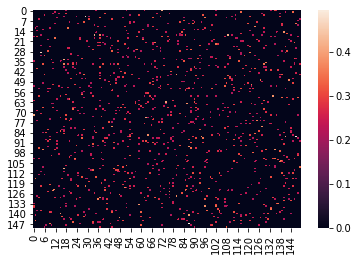

In [6]:
sns.heatmap(q)

0.0
0.1
0.2
0.30000000000000004


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


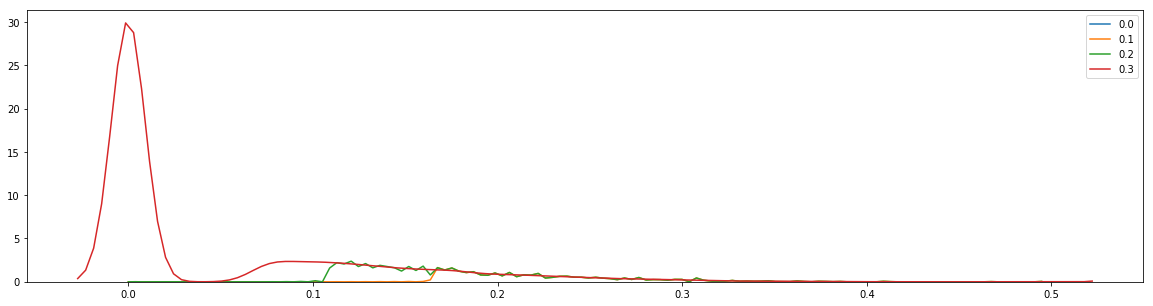

In [16]:
fig,ax = plt.subplots(figsize=(20,5))
for i in np.arange(0,0.4,0.1):
    print(i)
    w = bct.threshold_proportional(test, i)
    sns.distplot(np.ravel(w), hist=False, label=np.round(i,2))

In [95]:
subjects = ['101','102','103']
degree = []
thresh_df = pd.DataFrame(index=subjects, columns=['k_connected', 'k_skewed'])
for subject in subjects:
    matrix = pd.read_csv('/Volumes/Macintosh HD/Users/Katie/Dropbox/Projects/physics-retrieval/data/out/{0}-phy-corrmat-regionwise.csv'.format(subject), 
                         header=0, index_col=0).values
    kappa = 0.01
    skewness = 1
    while skewness > 0.3:
        w = bct.threshold_proportional(matrix, kappa)
        skewness = skew(bct.degrees_und(w))
        kappa_lower += 0.01
    thresh_df.at[subject,'k_skewed'] = kappa
    kappa = 0.01
    num = 2
    while num > 1:
        w = bct.threshold_proportional(matrix, kappa)
        [comp, num] = bct.get_components(w)
        num = np.unique(comp).shape[0]
        kappa_lower += 0.01
    thresh_df.at[subject,'k_connected'] = kappa

0.49000000000000027 0.9500000000000004
0.4300000000000002 0.9500000000000004
0.45000000000000023 0.9500000000000004


In [97]:
thresh_df

,k_connected,k_skewed
101,0.49,0.13
102,0.43,0.1
103,0.45,0.16


0.05 0.7049494102234154
0.1 0.705611498005783
0.15000000000000002 0.2908224065394344
0.2 0.05743897955294058
0.25 -0.01141129752621506
0.3 -0.09514865864478728
0.35000000000000003 -0.25878592047055404
0.4 -0.4912972791465736
0.45 -0.5650443013975339


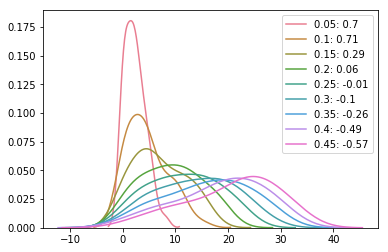

In [79]:
ranger = np.arange(0.05,kappa_lower,0.05)
for i in ranger:
    sns.set_palette('husl', ranger.shape[0], desat=0.8)
    thresh = bct.threshold_proportional(matrix,i)
    degrees = bct.degrees_und(thresh)
    print(i, skew(degrees))
    sns.kdeplot(degrees, label='{0}: {1}'.format(np.round(i,2), np.round(skew(degrees),2)))

In [75]:
from scipy.stats import skew

In [76]:
skew(degrees)

-0.5650443013975339